## Import Libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pandas_ta as ta

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
SEED = 24756
np.random.seed(SEED)

In [10]:
sns.set_style(style="whitegrid")
sns.set_color_codes(palette="deep")   

## Data

### Import

In [6]:
dang = pd.read_csv("data/DANGCEM_historical.csv")

dang.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,26/01/2024,694.1,694.1,694.1,694.1,218.29K,0.00%
1,25/01/2024,694.1,694.1,694.1,694.1,196.77K,0.00%
2,24/01/2024,694.1,651.8,694.1,694.1,1.05M,6.49%
3,23/01/2024,651.8,592.6,651.8,600.0,5.07M,9.99%
4,22/01/2024,592.6,592.6,592.6,592.6,2.02M,9.99%


### Inspection

In [8]:
dang.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2740 entries, 0 to 2739
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      2740 non-null   object 
 1   Price     2740 non-null   float64
 2   Open      2740 non-null   float64
 3   High      2740 non-null   float64
 4   Low       2740 non-null   float64
 5   Vol.      2740 non-null   object 
 6   Change %  2740 non-null   object 
dtypes: float64(4), object(3)
memory usage: 150.0+ KB


### Cleaning

In [7]:
# Clean and rename columns
dang = dang.rename(columns={"Price": "close", "Vol.": "volume", "Change %": "perct_change"})
# Convert case to lower case
dang.columns = dang.columns.str.lower()
dang.head()

,date,close,open,high,low,volume,perct_change
0,26/01/2024,694.1,694.1,694.1,694.1,218.29K,0.00%
1,25/01/2024,694.1,694.1,694.1,694.1,196.77K,0.00%
2,24/01/2024,694.1,651.8,694.1,694.1,1.05M,6.49%
3,23/01/2024,651.8,592.6,651.8,600.0,5.07M,9.99%
4,22/01/2024,592.6,592.6,592.6,592.6,2.02M,9.99%


In [8]:
# Change date data-type to date
dang["date"] = pd.to_datetime(dang["date"], dayfirst=True)
dang["date"].dtypes

dtype('<M8[ns]')

In [9]:
# Clean percentage change variable. remove "%" signs
dang["perct_change"] = dang["perct_change"].str.replace("%", "").str.strip().astype("float64")
dang["perct_change"].dtypes

dtype('float64')

In [10]:
def convert_unit(x):
    """ 
    Convert volume unit to the approprate unit.
    """

    # Extract the unit e.g (K, M)
    unit = x[-1].upper()
    # Extract the numeric value
    value = float(x[:-1])

    if unit == "K":
        return value * 1000
    elif unit == "M":
        return value * 1000000
    else:
        # No unit as-is
        return value

# convert_unit("10.45X")
dang["volume"] = dang["volume"].apply(convert_unit)
dang["volume"].dtypes

dtype('float64')

In [11]:
# volume Outlier
dang["volume"].describe()

count    2.740000e+03
mean     1.665976e+06
std      1.502695e+07
min      8.200000e+02
25%      1.046225e+05
50%      3.382450e+05
75%      9.843625e+05
max      5.500900e+08
Name: volume, dtype: float64

In [12]:
dang.isnull().sum()

date            0
close           0
open            0
high            0
low             0
volume          0
perct_change    0
dtype: int64

In [13]:
def winsorize(df, var, lower_percentile=5, upper_percentile=95):
    """
    Winsorizes a pandas series by capping outliers at specified percentiles.
    """
    
    # Copy data 
    f_df = df.copy()
    # Calculate lower and upper limites based on percentiles
    lower_limit = np.percentile(f_df[var], lower_percentile)
    upper_limit = np.percentile(f_df[var], upper_percentile)

    # Apply Winsorization
    f_df[var] = f_df[var].clip(lower_limit, upper_limit)

    return f_df

In [14]:
dang = winsorize(dang, "volume")

In [19]:
def clean_data(data_path:str, winsorize_volume:bool=True) -> pd.DataFrame:
    """ 
    """

    dang = pd.read_csv(data_path)
    
    # Clean and rename columns
    dang = dang.rename(columns={"Price": "close", "Vol.": "volume", "Change %": "perct_change"})
    # Convert case to lower case
    dang.columns = dang.columns.str.lower()

    # Change date data-type to date
    dang["date"] = pd.to_datetime(dang["date"], dayfirst=True)

    # Clean percentage change variable. remove "%" signs
    dang["perct_change"] = dang["perct_change"].str.replace("%", "").str.strip().astype("float64")

    def convert_unit(x):
        # Extract the unit e.g (K, M)
        unit = x[-1].upper()
        # Extract the numeric value
        value = float(x[:-1])
        if unit == "K":
            return value * 1000
        elif unit == "M":
            return value * 1000000
        else:
            # No unit as-is
            return value

    # convert_unit("10.45X")
    dang["volume"] = dang["volume"].apply(convert_unit)

    def winsorize(df, var, lower_percentile=5, upper_percentile=95):
        # Copy data 
        f_df = df.copy()
        # Calculate lower and upper limites based on percentiles
        lower_limit = np.percentile(f_df[var], lower_percentile)
        upper_limit = np.percentile(f_df[var], upper_percentile)

        # Apply Winsorization
        f_df[var] = f_df[var].clip(lower_limit, upper_limit)

        return f_df
    
    if winsorize_volume:
        dang = winsorize(dang, "volume")

    return dang

In [20]:
clean_data("data/DANGCEM_historical.csv").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2740 entries, 0 to 2739
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          2740 non-null   datetime64[ns]
 1   close         2740 non-null   float64       
 2   open          2740 non-null   float64       
 3   high          2740 non-null   float64       
 4   low           2740 non-null   float64       
 5   volume        2740 non-null   float64       
 6   perct_change  2740 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 150.0 KB


In [37]:
# dang

end_date = pd.to_datetime("2023-12-31")

dang = dang.loc[dang["date"] <= end_date]

### Save 

In [38]:
dang.to_csv("data/dangcem.csv", index=False)

## Explorative Data Analysis

#### Distribution

In [7]:
def distribution_plot(df:pd.DataFrame, var_name:str, plt_title:str=None):
    
    plt_title = plt_title if plt_title is not None else str.title(var_name) + " Price"

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

    # Histogram subplot
    sns.histplot(data=df, x=var_name, ax=ax1)
    ax1.set_title(f"{plt_title} Distribution (2013 -  2023)")

    # Boxplot subplot
    sns.boxplot(data=df, x=var_name, ax=ax2)
    plt.tight_layout()

##### Close

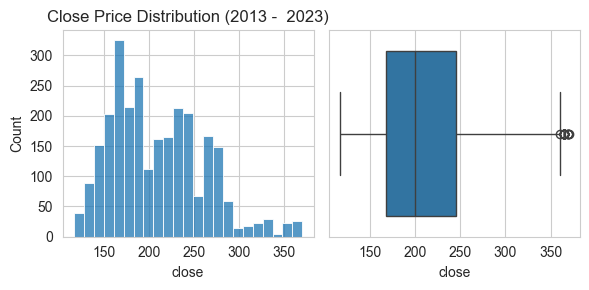

In [8]:
distribution_plot(dang, "close")
plt.savefig('images/stock_close_dist.png') 

##### Open

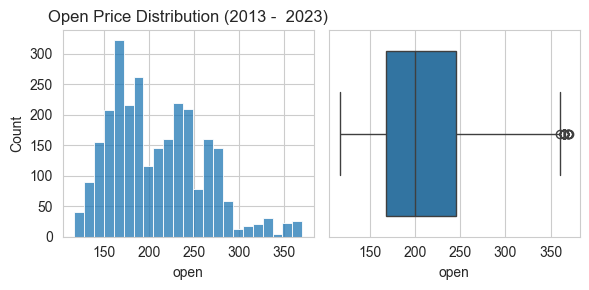

In [41]:
distribution_plot(dang, "open")

##### High

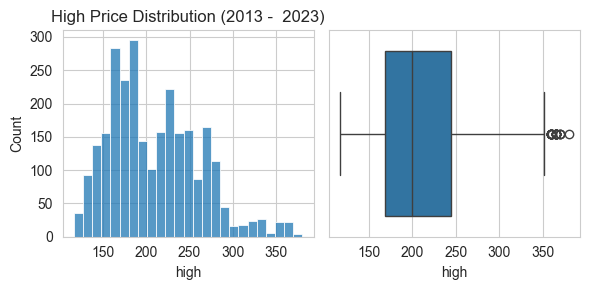

In [42]:
distribution_plot(dang, "high")

##### Low

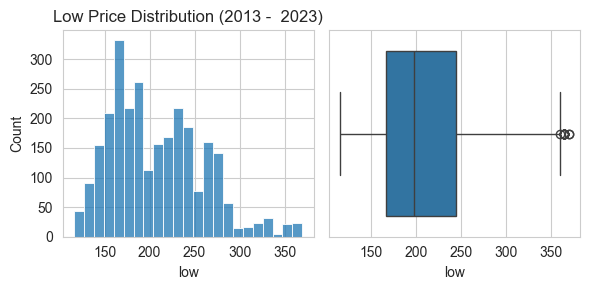

In [43]:
distribution_plot(dang, "low")

##### Volume

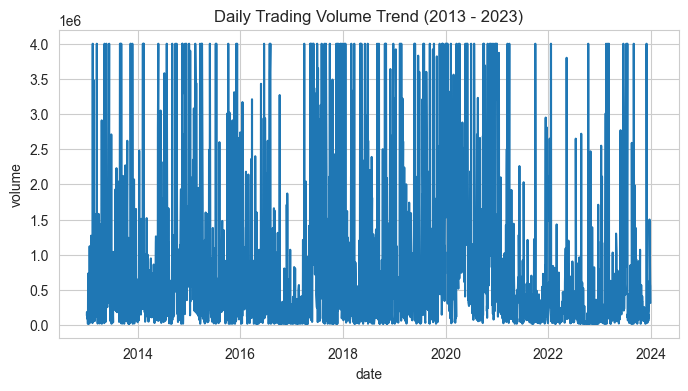

In [44]:
plt.figure(figsize=(8, 4))
sns.lineplot(
    data=dang,
    x="date",
    y="volume"
)
plt.title("Daily Trading Volume Trend (2013 - 2023)")
# Save the plot
# plt.savefig('images/init_mdls_rmse.png') 
plt.show()

In [45]:
print(f"Minimum volume: {dang['volume'].min():,}")
print(f"Maximum volume: {dang['volume'].max():,}") 

Minimum volume: 18,124.000000000007
Maximum volume: 4,000,000.0


### Stock Price Movement 

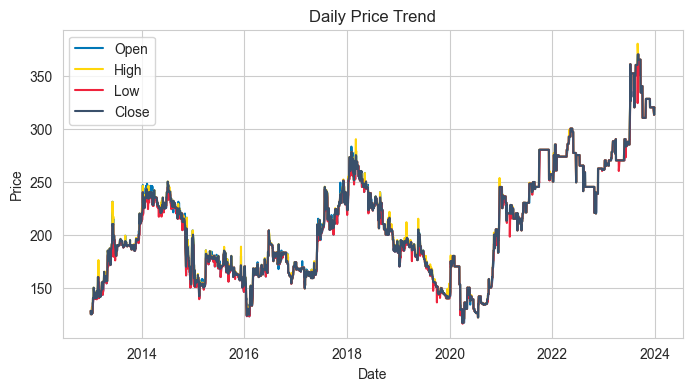

In [15]:
plt.figure(figsize=(8, 4))

plt.plot(dang["date"], dang["open"], label='Open', color='#0077B6')
plt.plot(dang["date"], dang["high"], label='High', color='#FFD60A')
plt.plot(dang["date"], dang["low"], label='Low', color='#EF233C')
plt.plot(dang["date"], dang["close"], label='Close', color='#3A506B')

plt.ylabel("Price")
plt.xlabel("Date")
plt.title("Daily Price Trend")
plt.legend()

plt.savefig('images/price_trend.png') 
plt.show()

#### Yearly pattern

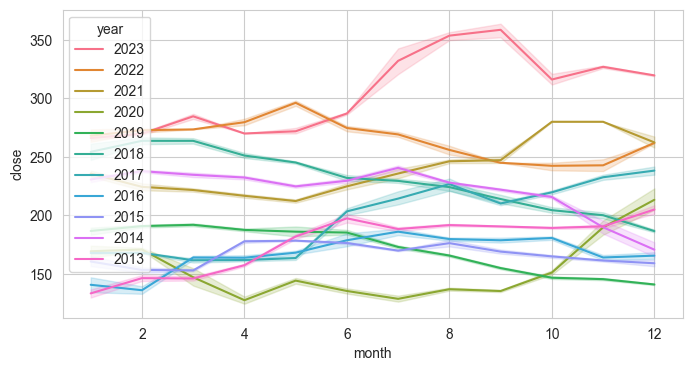

In [25]:
dang["year"] = dang["date"].dt.year
dang["year"] = dang["year"].astype(str)
dang["month"] = dang["date"].dt.month

plt.figure(figsize=(8, 4))

sns.lineplot(
    x="month",
    y="close",
    data=dang,
    hue="year"
)

plt.show()